# Download dataset:
Note: If you cannnot download using gdown, consider download manually and mount it to your colab

```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [1]:
#https://drive.google.com/file/d/124q1dlt2_fBBxr5JQW27Js2lBQ6Ql9zS/view?usp=sharing
!gdown --id 124q1dlt2_fBBxr5JQW27Js2lBQ6Ql9zS

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=124q1dlt2_fBBxr5JQW27Js2lBQ6Ql9zS
From (redirected): https://drive.google.com/uc?id=124q1dlt2_fBBxr5JQW27Js2lBQ6Ql9zS&confirm=t&uuid=9916ffa2-cc57-447d-bc1b-2a5c697dda59
To: /content/vqa_coco_dataset.zip
100% 196M/196M [00:08<00:00, 23.0MB/s]


In [2]:
!unzip -q vqa_coco_dataset.zip

# Import libraries

In [3]:
!pip install timm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.4 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torchtext
import os
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision import transforms

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

# Read dataset

In [5]:
train_data = []
train_set_path = './vaq2.0.TrainImages.txt'

with open(train_set_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }

        train_data.append(data_sample)

df_train = pd.DataFrame(train_data)
df_train.head()

,image_path,question,answer
0,COCO_val2014_000000393225.jpg,Is this a creamy soup ?,no
1,COCO_val2014_000000393243.jpg,Is this person wearing a tie ?,no
2,COCO_val2014_000000262197.jpg,Is this a hospital ?,yes
3,COCO_val2014_000000393277.jpg,Are there any tour buses ?,no
4,COCO_val2014_000000393277.jpg,Is this a one way street ?,no


In [6]:

val_data = []
val_set_path = './vaq2.0.DevImages.txt'

with open(val_set_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }

        val_data.append(data_sample)

df_val = pd.DataFrame(val_data)
df_val.head()

,image_path,question,answer
0,COCO_val2014_000000262175.jpg,Is this a designer tie ?,no
1,COCO_val2014_000000393284.jpg,Is this man snowboarding ?,yes
2,COCO_val2014_000000000133.jpg,Is this a child room ?,yes
3,COCO_val2014_000000000133.jpg,Could this be child room ?,yes
4,COCO_val2014_000000240323.jpg,Is this a vegetarian meal ?,no


In [7]:
test_data = []
test_set_path = './vaq2.0.TestImages.txt'

with open(test_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        test_data.append(data_sample)
df_test = pd.DataFrame(test_data)
df_test.head()

,image_path,question,answer
0,COCO_val2014_000000262162.jpg,Are there any boxes in the room ?,no
1,COCO_val2014_000000393277.jpg,Are there any any tour buses ?,no
2,COCO_val2014_000000393284.jpg,Is this person flying ?,no
3,COCO_val2014_000000262376.jpg,Is this a big building ?,yes
4,COCO_val2014_000000524611.jpg,Could this be parking lot for bikes ?,no


# Data processing

## Building vocab

In [8]:
eng = spacy.load('en_core_web_sm') # load the English model to tokenize

def get_tokens(data_iter):
    for sample in data_iter:
        question = sample['question']

        yield [token.text for token in eng.tokenizer(question)]

vocab = build_vocab_from_iterator(
    get_tokens(train_data),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab.set_default_index(vocab['<unk>'])

In [9]:

len(vocab)

1678

In [10]:
def tokenize(question, max_seq_len):
    tokens = [token.text for token in eng.tokenizer(question)]
    sequence = [vocab[token] for token in tokens]
    if len(sequence) < max_seq_len:
        sequence += [vocab['<pad>']] * (max_seq_len - len(sequence))
    else:
        sequence = sequence[:max_seq_len]

    return sequence

In [11]:
example_question = "Is this a picture of a cat?"
max_seq_len = 20

encoded_question = tokenize(example_question, max_seq_len)

In [12]:
def detokenize(indices):
    decoded_sentece = []
    for idx in indices:
        token = vocab.lookup_token(idx)
        if token not in ['<pad>', '<sos>', '<eos>', '<unk>']:
            decoded_sentece.append(token)
    return decoded_sentece

In [13]:
detokenize(encoded_question)

['Is', 'this', 'a', 'picture', 'of', 'a', 'cat', '?']

In [14]:
classes = set([sample['answer'] for sample in train_data])
classes_to_idx = {
    cls:idx for idx, cls in enumerate(classes)
}
idx_to_classes = {
    idx:cls for idx, cls in enumerate(classes)
}

In [15]:
print(idx_to_classes)

{0: 'yes', 1: 'no'}


# Create Pytorch dataset

In [16]:
class VQADataset(Dataset):
    def __init__(self, data, classes_to_idx, max_seq_len=20, transform=None, root_dir='/content/val2014-resised/'):
        self.transform = transform
        self.data = data
        self.max_seq_len = max_seq_len
        self.root_dir = root_dir
        self.classes_to_idx = classes_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data[idx]['image_path'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(image)

        question = self.data[idx]['question']
        question = tokenize(question, self.max_seq_len)
        question = torch.tensor(question, dtype=torch.long)

        label = self.data[idx]['answer']
        label = classes_to_idx[label]
        label = torch.tensor(label, dtype=torch.long)

        return img, question, label

In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # based on dataset
])

In [18]:
train_dataset = VQADataset(train_data,
                           classes_to_idx=classes_to_idx,
                           transform=transform)
val_dataset = VQADataset(val_data,
                         classes_to_idx=classes_to_idx,
                         transform=transform)
test_dataset = VQADataset(test_data,
                          classes_to_idx=classes_to_idx,
                          transform=transform)

In [19]:
train_batch_size = 128
test_batch_size = 32

train_loader = DataLoader(train_dataset,
                          batch_size=train_batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=test_batch_size,
                        shuffle=False)
test_loader = DataLoader(test_dataset,
                         batch_size=test_batch_size,
                         shuffle=False)

# Create Model

In [20]:
class VQAModel(nn.Module):
    def __init__(self, n_classes, img_model_name='resnet50', embedding_dim=300, n_layers=1, hidden_size=128, dropout_prob=0.2):
        super().__init__()
        self.image_encoder = timm.create_model(img_model_name,
                                               pretrained=True,
                                               num_classes=hidden_size)
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.lstm1 = nn.LSTM(input_size=embedding_dim,
                             hidden_size=hidden_size,
                             num_layers=n_layers,
                             batch_first=True,
                             bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=hidden_size*3, # concat img_enc + 2 (bi) from text
                             hidden_size=hidden_size,
                             num_layers=n_layers,
                             batch_first=True,
                             bidirectional=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size * 2, n_classes)

    def forward(self, img, text):
        img_features = self.image_encoder(img)

        text_emb = self.embedding(text)
        lstm_out, _ = self.lstm1(text_emb) #(batch, seq, feature)

        lstm_out = lstm_out[:, -1, :] # taking the last embed

        combined = torch.cat((img_features, lstm_out), dim=1)
        x, _ = self.lstm2(combined)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [21]:

n_classes = len(classes)
img_model_name = 'resnet50'
hidden_size = 128
n_layers = 1
embedding_dim = 64
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VQAModel(n_classes=n_classes,
                 img_model_name=img_model_name,
                 embedding_dim=embedding_dim,
                 n_layers=n_layers,
                 hidden_size=hidden_size,
                 dropout_prob=dropout_prob).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [22]:
images, questions, labels = next(iter(train_loader))

model.eval()
with torch.no_grad():
    images = images.to(device)
    questions = questions.to(device)
    output = model(images, questions)
    print(output.shape)

torch.Size([128, 2])


# Training

In [23]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for image, question, labels in dataloader:
            image, question, labels = image.to(device), question.to(device), labels.to(device)
            outputs = model(image, question)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [24]:
def fit(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (images, questions, labels) in enumerate(train_loader):
            images = images.to(device)
            questions = questions.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses

In [25]:
lr = 1e-2
epochs = 50

scheduler_step_size = epochs * 0.6
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [26]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 0.7169	Val loss: 0.6923	Val Acc: 0.4979508196721312
EPOCH 2:	Train loss: 0.6985	Val loss: 0.6905	Val Acc: 0.5358606557377049
EPOCH 3:	Train loss: 0.6952	Val loss: 0.6935	Val Acc: 0.5394467213114754
EPOCH 4:	Train loss: 0.6941	Val loss: 0.6939	Val Acc: 0.4636270491803279
EPOCH 5:	Train loss: 0.6943	Val loss: 0.6916	Val Acc: 0.5394467213114754
EPOCH 6:	Train loss: 0.6933	Val loss: 0.6900	Val Acc: 0.5404713114754098
EPOCH 7:	Train loss: 0.6954	Val loss: 0.6932	Val Acc: 0.4661885245901639
EPOCH 8:	Train loss: 0.6937	Val loss: 0.6916	Val Acc: 0.5358606557377049
EPOCH 9:	Train loss: 0.6927	Val loss: 0.6955	Val Acc: 0.4641393442622951
EPOCH 10:	Train loss: 0.6936	Val loss: 0.6911	Val Acc: 0.5358606557377049
EPOCH 11:	Train loss: 0.6930	Val loss: 0.6919	Val Acc: 0.5368852459016393
EPOCH 12:	Train loss: 0.6928	Val loss: 0.6912	Val Acc: 0.53125
EPOCH 13:	Train loss: 0.6925	Val loss: 0.6903	Val Acc: 0.5379098360655737
EPOCH 14:	Train loss: 0.6929	Val loss: 0.6932	Val Acc: 0.5

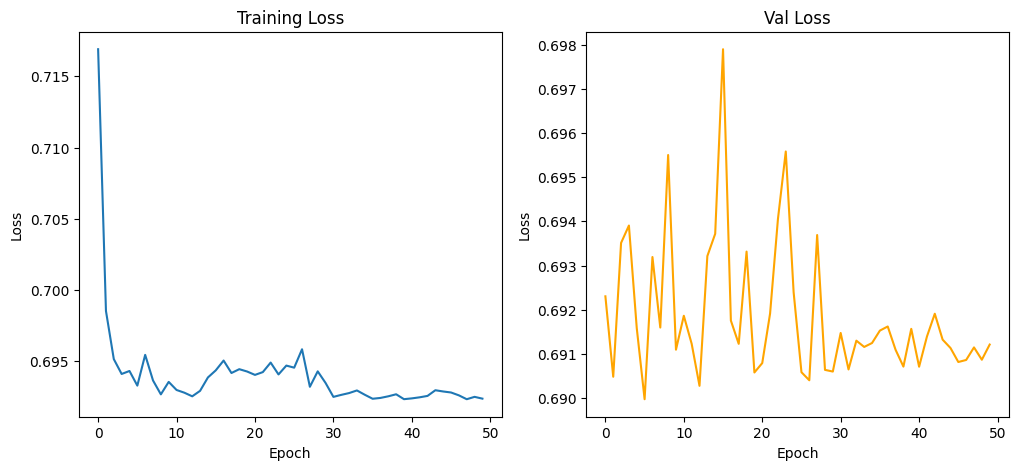

In [27]:

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

# Evaluation

In [28]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.5358606557377049
Test accuracy:  0.5489614243323442


# Print some examples

In [29]:
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).reshape(3, 1, 1)
    std = torch.tensor(std).reshape(3, 1, 1)
    return tensor * std + mean

Question: ['Is', 'this', 'person', 'flying', '?']
True Label: no
Predicted Label: no
Question: ['this', 'be', 'recent', 'picture', '?']
True Label: no
Predicted Label: no
Question: ['Is', 'this', 'a', 'pizza', '?']
True Label: yes
Predicted Label: no


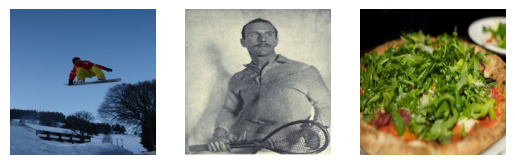

In [30]:
import random
images, questions, labels = next(iter(test_loader))

num_examples = 3
indices = random.sample(range(images.shape[0]), num_examples)

random_images = images[indices]
random_questions = questions[indices]
random_labels = labels[indices]

for i in range(num_examples):
    image = random_images[i]
    question = random_questions[i]
    label = idx_to_classes[random_labels[i].item()]

    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)
        question_tensor = question.unsqueeze(0).to(device)

        output = model(image_tensor, question_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted = idx_to_classes[predicted_idx.item()]

    print(f'Question: {detokenize(question.numpy())}')


    denormalized_image = denormalize(image, mean, std)
    image = denormalized_image.cpu()

    plt.subplot(1, num_examples, i+1)
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.axis('off')

    print(f'True Label: {label}')
    print(f'Predicted Label: {predicted}')

plt.show()